In [38]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --------------------------
# 1. โหลดข้อมูล
# --------------------------
df_fun = pd.read_excel("stock_fun_group.xlsx")

# ✅ เลือกเฉพาะคอลัมน์ที่ต้องใช้
features = ["eps", "pe", "pbv", "percentyield", "marketcap"]

# --------------------------
# 2. Standardization (Z-score)
# --------------------------
scaler = StandardScaler()
scaled = scaler.fit_transform(df_fun[features])
df_scaled = pd.DataFrame(scaled, columns=[f + "_scaled" for f in features], index=df_fun.index)

# --------------------------
# 3. สร้างคะแนนรวม (Score)
# --------------------------
df_fun["score"] = (
    df_scaled["eps_scaled"]            # + EPS
    - df_scaled["pe_scaled"]           # - PE
    + df_scaled["pbv_scaled"]          # + PBV
    + df_scaled["percentyield_scaled"] # + Dividend Yield
    + df_scaled["marketcap_scaled"]    # + Market Cap
)

# --------------------------
# 4. แบ่งออกเป็น 5 กลุ่ม (Quantile)
# --------------------------
df_fun["fundamental_group"] = pd.qcut(
    df_fun["score"],
    q=5,
    labels=["E", "D", "C", "B", "A"]  # E = อ่อนสุด → A = แข็งสุด
)

# --------------------------
# 5. เตรียมข้อมูลสำหรับ Deep Learning
# --------------------------
X = df_scaled.values
y = df_fun["fundamental_group"]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# --------------------------
# 6. สร้างโมเดล Deep Learning
# --------------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --------------------------
# 7. เทรนโมเดล
# --------------------------
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

# --------------------------
# 8. ประเมินผล
# --------------------------
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"\n✅ Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

✅ Accuracy: 0.9583 | F1-score: 0.9583


In [39]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --------------------------
# 1. Load Data
# --------------------------
df_candle = pd.read_excel("stock_june2025_onwards.xlsx")

# ตรวจสอบคอลัมน์หลัก
print("Columns:", df_candle.columns.tolist())

# --------------------------
# 2. ฟังก์ชันคำนวณ trend_grade
# --------------------------
def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []

    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()
        df_sym = df_sym.dropna(subset=['close_price'])

        if len(df_sym) < 50:
            continue

        # ✅ Indicators
        df_sym['ema5']   = df_sym['close_price'].ewm(span=5).mean()
        df_sym['ema15']  = df_sym['close_price'].ewm(span=15).mean()
        df_sym['ema35']  = df_sym['close_price'].ewm(span=35).mean()
        df_sym['ema89']  = df_sym['close_price'].ewm(span=89).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200).mean()
        df_sym['rsi']    = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()

        df_sym = df_sym.dropna(subset=['ema5','ema15','ema35','ema89','ema200','rsi'])
        if df_sym.empty:
            continue

        row = df_sym.iloc[-1]
        c, r = row['close_price'], row['rsi']
        e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']

        if c >= e5 and r >= 70:
            grade = 'a'
        elif c >= e35 and e35 >= e89:
            grade = 'b'
        elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
            grade = 'c'
        elif c < e89 and c < e200 and e89 < e200:
            grade = 'd'
        elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
            grade = 'e'
        else:
            grade = 'c'

        df_result.append({
            'symbol': symbol,
            'time': row['time'],
            'close_price': row['close_price'],
            'high_price': row['high_price'],
            'low_price': row['low_price'],
            'open_price': row['open_price'],
            'value': row['value'],
            'ema5': e5, 'ema15': e15, 'ema35': e35, 'ema89': e89, 'ema200': e200,
            'rsi': r, 'trend_grade': grade
        })

    return pd.DataFrame(df_result)

# --------------------------
# 3. คำนวณ Trend Grade
# --------------------------
df_trend = compute_technical_grades(df_candle)
print(f"✅ ได้ข้อมูลทั้งหมด {len(df_trend)} แถว")

# --------------------------
# 4. เตรียมข้อมูลเทรน Deep Learning
# --------------------------
features = ['close_price', 'high_price', 'low_price', 'open_price', 'value',
            'ema5','ema15','ema35','ema89','ema200','rsi']

X = df_trend[features]
y = df_trend['trend_grade']

# ✅ Encode labels (a–e)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ✅ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# --------------------------
# 5. Deep Learning Model
# --------------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --------------------------
# 6. Train Model
# --------------------------
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

# --------------------------
# 7. Evaluate
# --------------------------
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n✅ Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

Columns: ['symbol', 'time', 'close_price', 'high_price', 'low_price', 'open_price', 'value', 'volume']
✅ ได้ข้อมูลทั้งหมด 856 แถว


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

✅ Accuracy: 0.7326 | F1-score: 0.6933


In [40]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. โหลด Fundamental Data
# --------------------------
df_fun = pd.read_excel("stock_fun_group.xlsx")[["symbol", "eps", "pe", "pbv", "percentyield", "marketcap", "fundamental_group"]]

# --------------------------
# 2. โหลด Candle Data แล้วสร้าง trend_grade
# --------------------------
df_candle = pd.read_excel("stock_june2025_onwards.xlsx")

def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []
    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()
        df_sym = df_sym.dropna(subset=['close_price'])
        if len(df_sym) < 50:
            continue
        df_sym['ema5']   = df_sym['close_price'].ewm(span=5).mean()
        df_sym['ema15']  = df_sym['close_price'].ewm(span=15).mean()
        df_sym['ema35']  = df_sym['close_price'].ewm(span=35).mean()
        df_sym['ema89']  = df_sym['close_price'].ewm(span=89).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200).mean()
        df_sym['rsi']    = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()
        df_sym = df_sym.dropna(subset=['ema5','ema15','ema35','ema89','ema200','rsi'])
        if df_sym.empty:
            continue
        row = df_sym.iloc[-1]
        c, r = row['close_price'], row['rsi']
        e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']
        if c >= e5 and r >= 70:
            grade = 'a'
        elif c >= e35 and e35 >= e89:
            grade = 'b'
        elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
            grade = 'c'
        elif c < e89 and c < e200 and e89 < e200:
            grade = 'd'
        elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
            grade = 'e'
        else:
            grade = 'c'

        df_result.append({
            'symbol': symbol,
            'close_price': row['close_price'],
            'high_price': row['high_price'],
            'low_price': row['low_price'],
            'open_price': row['open_price'],
            'value': row['value'],
            'ema5': e5, 'ema15': e15, 'ema35': e35, 'ema89': e89, 'ema200': e200,
            'rsi': r, 'trend_grade': grade
        })
    return pd.DataFrame(df_result)

df_trend = compute_technical_grades(df_candle)
print(f"✅ Fundamental data: {df_fun.shape[0]} rows | Technical data: {df_trend.shape[0]} rows")

# --------------------------
# 3. รวมสองชุดข้อมูลด้วย symbol
# --------------------------
df_merge = pd.merge(df_fun, df_trend, on="symbol", how="inner")
print(f"✅ รวมข้อมูลได้ทั้งหมด {len(df_merge)} แถว")

✅ Fundamental data: 836 rows | Technical data: 856 rows
✅ รวมข้อมูลได้ทั้งหมด 799 แถว


In [41]:

# --------------------------
# 4. สร้าง Quadrant
# --------------------------
df_merge["quadrant"] = df_merge["fundamental_group"].astype(str) + df_merge["trend_grade"].astype(str)
print("ตัวอย่าง Quadrant:\n", df_merge[["symbol", "fundamental_group", "trend_grade", "quadrant"]].head())

ตัวอย่าง Quadrant:
   symbol fundamental_group trend_grade quadrant
0   PPPM                 D           d       Dd
1   TPCH                 A           c       Ac
2   POLY                 A           c       Ac
3   VCOM                 A           b       Ab
4    NVD                 E           d       Ed


In [42]:
df_merge.head()

,symbol,eps,pe,pbv,percentyield,marketcap,fundamental_group,close_price,high_price,low_price,open_price,value,ema5,ema15,ema35,ema89,ema200,rsi,trend_grade,quadrant
0,PPPM,0.02000,0.00,0.70,0.00,105500.001572,D,0.40,0.43,0.39,0.42,0,0.405345,0.413705,0.419833,0.428406,0.434019,40.720717,d,Dd
1,TPCH,0.24112,7.90,0.34,13.91,401575.987864,A,2.84,2.90,2.84,2.86,0,2.844297,2.849749,2.849346,2.849244,2.848840,47.825269,c,Ac
2,POLY,0.27632,12.89,2.42,6.38,152320.004272,A,6.80,7.05,6.80,6.90,0,6.829600,6.925563,6.948069,6.916856,6.896954,44.452126,c,Ac
3,VCOM,0.21428,7.85,1.48,10.79,303722.809988,A,2.90,2.94,2.90,2.92,0,2.899084,2.905416,2.884641,2.827082,2.789608,50.733075,b,Ab
4,NVD,-0.00942,38.87,0.32,0.00,4186.000121,E,0.91,0.93,0.91,0.93,0,0.924915,0.929716,0.935469,0.947964,0.955180,43.396960,d,Ed


In [43]:
df_merge.to_excel("stock_all_data.xlsx", index=False)

🚀 Running K-Means...
🌳 Running Decision Tree...
🔹 Running K-Nearest Neighbors...
🤖 Running ANN...


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
🧠 Running Deep Learning...


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

📊 MODEL PERFORMANCE SUMMARY


,Model,Accuracy,F1-Score
0,Artificial Neural Network (ANN),0.562500,0.500563
1,Deep Learning (Improved ANN),0.537500,0.504367
2,K-Nearest Neighbors (KNN),0.468750,0.447683
3,Decision Tree,0.456250,0.416173
4,K-Means (Unsupervised),0.067584,0.020737


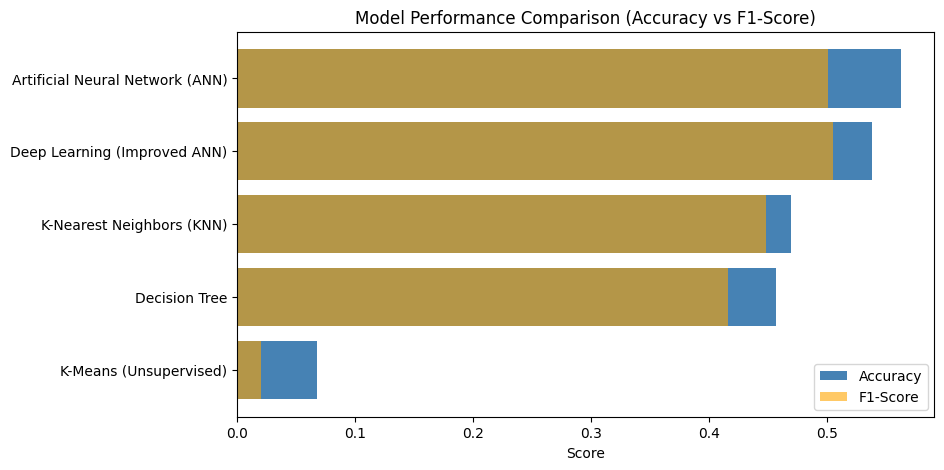

In [44]:
# ============================================================
# 🔰 Stock Quadrant Quantitative Analysis - Auto Model Pipeline
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Machine Learning Models
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# 1. โหลดข้อมูล
# -----------------------------
df = pd.read_excel("stock_all_data.xlsx")

features = ["eps", "pe", "pbv", "percentyield", "marketcap",
            "close_price", "high_price", "low_price", "open_price",
            "value", "ema5", "ema15", "ema35", "ema89", "ema200", "rsi"]

df = df.dropna(subset=features + ["quadrant"])
X = df[features]
y = df["quadrant"]

# -----------------------------
# 2. เตรียมข้อมูล
# -----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# -----------------------------
# 3. เริ่มเก็บผลลัพธ์
# -----------------------------
results = []

# ============================================================
# ✅ 1. K-Means (Baseline)
# ============================================================
print("🚀 Running K-Means...")
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
acc_kmeans = accuracy_score(y_encoded, clusters)
f1_kmeans = f1_score(y_encoded, clusters, average="weighted", zero_division=0)
results.append(["K-Means (Unsupervised)", acc_kmeans, f1_kmeans])

# ============================================================
# ✅ 2. Decision Tree
# ============================================================
print("🌳 Running Decision Tree...")
tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree, average="weighted")
results.append(["Decision Tree", acc_tree, f1_tree])

# ============================================================
# ✅ 3. KNN
# ============================================================
print("🔹 Running K-Nearest Neighbors...")
knn_model = KNeighborsClassifier(n_neighbors=7, weights="distance")
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average="weighted")
results.append(["K-Nearest Neighbors (KNN)", acc_knn, f1_knn])

# ============================================================
# ✅ 4. ANN (Basic Neural Network)
# ============================================================
print("🤖 Running ANN...")
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

ann = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ann.fit(X_train, y_train_cat, epochs=40, batch_size=16, verbose=0)
loss_ann, acc_ann = ann.evaluate(X_test, y_test_cat, verbose=0)
y_pred_ann = ann.predict(X_test)
y_pred_ann_class = np.argmax(y_pred_ann, axis=1)
f1_ann = f1_score(y_test, y_pred_ann_class, average="weighted")
results.append(["Artificial Neural Network (ANN)", acc_ann, f1_ann])

# ============================================================
# ✅ 5. Deep Learning (Improved ANN)
# ============================================================
print("🧠 Running Deep Learning...")
deep = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(), Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(), Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(), Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])
deep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
deep.fit(X_train, y_train_cat, validation_split=0.2, epochs=100, batch_size=16, verbose=0, callbacks=[early_stop])
loss_deep, acc_deep = deep.evaluate(X_test, y_test_cat, verbose=0)
y_pred_deep = deep.predict(X_test)
y_pred_deep_class = np.argmax(y_pred_deep, axis=1)
f1_deep = f1_score(y_test, y_pred_deep_class, average="weighted")
results.append(["Deep Learning (Improved ANN)", acc_deep, f1_deep])

# ============================================================
# ✅ 6. สรุปผลลัพธ์ทั้งหมด
# ============================================================
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "F1-Score"])
df_results = df_results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n📊 MODEL PERFORMANCE SUMMARY")
display(df_results)

# ============================================================
# ✅ 7. วาดกราฟเปรียบเทียบ
# ============================================================
plt.figure(figsize=(9,5))
plt.barh(df_results["Model"], df_results["Accuracy"], color="steelblue", label="Accuracy")
plt.barh(df_results["Model"], df_results["F1-Score"], color="orange", alpha=0.6, label="F1-Score")
plt.title("Model Performance Comparison (Accuracy vs F1-Score)")
plt.xlabel("Score")
plt.legend()
plt.gca().invert_yaxis()
plt.show()


DEPLOYMENT

In [50]:
# -----------------------------
# หลังจาก train deep_model เสร็จแล้ว
# -----------------------------
deep_model.save("deep_quadrant_model.h5")   # บันทึกโมเดล
print("✅ Saved model to deep_quadrant_model.h5")

import joblib
joblib.dump(scaler, "scaler.pkl")           # บันทึก Scaler
joblib.dump(le, "label_encoder.pkl")        # บันทึก Label Encoder
print("✅ Saved scaler.pkl and label_encoder.pkl")


✅ Saved model to deep_quadrant_model.h5
✅ Saved scaler.pkl and label_encoder.pkl


In [51]:
# ============================================================
# 🔰 Deployment: Predict Quadrant (Cassandra + Auto Compute Indicators + Marketcap)
# ============================================================

from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# -----------------------------
# 1. Connect Cassandra (Local)
# -----------------------------
def connect_cassandra():
    cluster = Cluster(['127.0.0.1'])
    session = cluster.connect()
    session.set_keyspace('data_stock')  # 👈 ตั้ง keyspace ให้ตรงกับที่คุณสร้างไว้
    return session


# -----------------------------
# 2. ดึงข้อมูลจาก Cassandra
# -----------------------------
def get_stock_data(session, symbol):
    # ข้อมูลราคาหลัก
    q_price = f"""
        SELECT time, close_price, high_price, low_price, open_price, value
        FROM candlestick_data
        WHERE symbol='{symbol}'
        LIMIT 300;
    """
    # ข้อมูล volume สำหรับคำนวณ marketcap
    q_vol = f"""
        SELECT time, volume
        FROM candlestick1_1068_data
        WHERE symbol='{symbol}'
        LIMIT 300;
    """
    # ข้อมูลพื้นฐาน
    q_fund = f"""
        SELECT eps, pe, pbv, percentyield
        FROM financal_data_fromsettradeAPI
        WHERE symbol='{symbol}'
        LIMIT 1;
    """

    df_price = pd.DataFrame(session.execute(q_price).all())
    df_vol = pd.DataFrame(session.execute(q_vol).all())
    fund = session.execute(q_fund).one()

    if df_price.empty or df_vol.empty or not fund:
        raise ValueError(f"❌ ไม่มีข้อมูลครบสำหรับ {symbol}")

    df_price = df_price.sort_values("time")
    df_vol = df_vol.sort_values("time")

    # รวม price + volume ตามเวลา
    df = pd.merge(df_price, df_vol, on="time", how="inner")
    df["marketcap"] = df["close_price"] * df["volume"]

    return df, fund._asdict()


# -----------------------------
# 3. คำนวณ EMA และ RSI
# -----------------------------
def compute_indicators(df):
    # EMA หลายช่วงเวลา
    df["ema5"] = df["close_price"].ewm(span=5, adjust=False).mean()
    df["ema15"] = df["close_price"].ewm(span=15, adjust=False).mean()
    df["ema35"] = df["close_price"].ewm(span=35, adjust=False).mean()
    df["ema89"] = df["close_price"].ewm(span=89, adjust=False).mean()
    df["ema200"] = df["close_price"].ewm(span=200, adjust=False).mean()

    # RSI 14
    delta = df["close_price"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["rsi"] = 100 - (100 / (1 + rs))

    df = df.dropna().reset_index(drop=True)
    return df


# -----------------------------
# 4. ทำนาย Quadrant ด้วย Deep Learning
# -----------------------------
def predict_quadrant(symbol):
    session = connect_cassandra()
    df, fund_data = get_stock_data(session, symbol)
    df = compute_indicators(df)

    # ใช้ข้อมูลล่าสุด (แถวสุดท้าย)
    last = df.iloc[-1]

    input_data = {
        **fund_data,
        "marketcap": last["marketcap"],
        "close_price": last["close_price"],
        "high_price": last["high_price"],
        "low_price": last["low_price"],
        "open_price": last["open_price"],
        "value": last["value"],
        "ema5": last["ema5"],
        "ema15": last["ema15"],
        "ema35": last["ema35"],
        "ema89": last["ema89"],
        "ema200": last["ema200"],
        "rsi": last["rsi"]
    }

    # เรียงฟีเจอร์ให้ตรงกับที่เทรนโมเดล
    features = ["eps", "pe", "pbv", "percentyield", "marketcap",
                "close_price", "high_price", "low_price", "open_price",
                "value", "ema5", "ema15", "ema35", "ema89", "ema200", "rsi"]

    X = np.array([[input_data[f] for f in features]])

    # โหลดโมเดลและเครื่องมือ
    deep_model = load_model("deep_quadrant_model.h5")
    scaler = joblib.load("scaler.pkl")
    le = joblib.load("label_encoder.pkl")

    # สเกลข้อมูล
    X_scaled = scaler.transform(X)
    y_pred = deep_model.predict(X_scaled)
    y_class = np.argmax(y_pred, axis=1)
    quadrant = le.inverse_transform(y_class)[0]

    return quadrant, input_data


# -----------------------------
# 5. ทดสอบระบบ
# -----------------------------
try:
    symbol = input("🔎 พิมพ์ชื่อหุ้น (เช่น AOT): ").upper()
    quadrant, used_data = predict_quadrant(symbol)

    print(f"\n✅ หุ้น {symbol} อยู่ใน Quadrant → {quadrant}")
    print("\n📊 ข้อมูลที่ใช้ในการวิเคราะห์:")
    for k, v in used_data.items():
        print(f"  {k:15s}: {v:.2f}")

except Exception as e:
    print("❌ เกิดข้อผิดพลาด:", e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



✅ หุ้น AOT อยู่ใน Quadrant → Ab

📊 ข้อมูลที่ใช้ในการวิเคราะห์:
  eps            : 1.00
  pe             : 29.10
  pbv            : 4.25
  percentyield   : 2.09
  marketcap      : 1266001848.00
  close_price    : 72.00
  high_price     : 73.00
  low_price      : 72.00
  open_price     : 72.75
  value          : 0.00
  ema5           : 72.39
  ema15          : 71.91
  ema35          : 71.51
  ema89          : 71.55
  ema200         : 71.91
  rsi            : 59.26


In [52]:
# ============================================================
# 🔰 Predict Multiple Stocks and Combine into DataFrame
# ============================================================

import pandas as pd

# สมมติว่าคุณมีฟังก์ชันนี้จากขั้นตอนก่อนหน้าแล้ว
# def predict_quadrant(symbol): -> return quadrant, input_data

# -----------------------------
# 1. รายชื่อหุ้นที่ต้องการทำนาย
# -----------------------------
symbols = ["DELTA", "PTT", "AOT", "ADVANC", "KBANK", 
           "TRUE", "GULF", "SCB", "KTC", "KTB", "CPALL"]

# -----------------------------
# 2. วนลูปทำนายหุ้นแต่ละตัว
# -----------------------------
results = []
for sym in symbols:
    try:
        quadrant, data_used = predict_quadrant(sym)
        row = {"Symbol": sym, "Quadrant": quadrant}
        row.update(data_used)  # รวมฟีเจอร์ที่ใช้ในการทำนาย (optional)
        results.append(row)
        print(f"✅ {sym} → {quadrant}")
    except Exception as e:
        print(f"❌ {sym}: {e}")

# -----------------------------
# 3. รวมผลเป็น DataFrame
# -----------------------------
df_pred = pd.DataFrame(results)

# แสดงเฉพาะคอลัมน์สำคัญ
cols_show = ["Symbol", "Quadrant", "eps", "pe", "pbv", "percentyield", 
             "marketcap", "close_price", "ema5", "ema15", "ema35", "rsi"]
df_show = df_pred[cols_show].round(2)

print("\n📊 ผลการทำนายทั้งหมด:")
display(df_show)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ DELTA → Ac


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ PTT → Ad


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ AOT → Ab


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ ADVANC → Ac


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ KBANK → Ab


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ TRUE → Ab


❌ GULF: ❌ ไม่มีข้อมูลครบสำหรับ GULF


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ SCB → Ab


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ KTC → Ab


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ KTB → Ac


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
✅ CPALL → Ab

📊 ผลการทำนายทั้งหมด:


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,Symbol,Quadrant,eps,pe,pbv,percentyield,marketcap,close_price,ema5,ema15,ema35,rsi
0,DELTA,Ac,0.81,100.50,21.75,0.31,5.194120e+08,109.00,108.85,107.59,106.02,58.73
1,PTT,Ad,1.57,12.86,0.80,6.62,1.744858e+09,34.75,35.07,35.33,34.93,30.77
2,AOT,Ab,1.00,29.10,4.25,2.09,1.266002e+09,72.00,72.39,71.91,71.51,59.26
3,ADVANC,Ac,7.25,21.85,8.51,3.65,9.322627e+08,213.00,215.24,217.95,218.91,31.82
4,KBANK,Ab,5.67,8.09,0.68,7.19,8.519348e+08,130.50,130.65,130.06,129.43,62.07
5,TRUE,Ab,0.11,0.00,5.08,0.00,8.345208e+08,8.70,8.54,8.43,8.20,52.38
6,SCB,Ab,7.51,9.03,0.90,8.12,7.943464e+08,118.50,117.80,116.09,113.50,76.19
7,KTC,Ab,1.46,9.46,1.78,4.76,2.434419e+08,47.00,47.87,47.60,47.57,55.56
8,KTB,Ac,0.84,7.54,0.74,6.44,8.139685e+08,19.00,19.28,19.52,19.64,35.48
9,CPALL,Ab,1.57,14.91,3.18,3.00,1.141302e+09,64.50,64.99,64.30,63.45,67.86
